In [1]:
import numpy as np
import pandas as pd
from k_means_constrained import KMeansConstrained
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
GLOVE_FILE = "glove.840B.300d.txt"
DIMS = 300

embeddings_index = {}
with open(GLOVE_FILE) as f:
    for line in f:
        splitted = line.split()
        # this is awful, but it's awful and it works
        word, coefs = " ".join(splitted[:len(splitted) - DIMS]), splitted[-DIMS:]
        coefs = np.array(coefs, dtype=float)
        embeddings_index[word] = coefs

In [3]:
CONNECTIONS_DATA = "connections.csv"
conn = pd.read_csv(CONNECTIONS_DATA, keep_default_na=False)
conn.iloc[664:668, :]

,0,1,2,3,clue
664,CO,MA,ME,PA,STATE ABBREVIATIONS
665,DO,FA,LA,TI,MUSICAL NOTES
666,MU,NU,PI,XI,GREEK LETTERS
667,FE,HE,NA,NI,PERIODIC TABLE SYMBOLS


In [4]:
unk_words = set(word for word in conn.iloc[:, 0:4].to_numpy().flatten() if str(word).lower() not in embeddings_index)
unk_words

{'BEACH BOY',
 'BLACK WIDOW',
 'CANDY CANE',
 'CAT EYE',
 'CLOUD NINE',
 'FAST ONE',
 'FIRE TRUCK',
 'FRESH AIR',
 'GET OUT',
 'GOLF COURSE',
 'HIGH FIVE',
 'I RAN',
 'ICE CUBE',
 'LOST BOYS',
 'MARY JANE',
 'MASHED POTATO',
 'MILKY WAY',
 'MOLE RAT',
 'NEAR DARK',
 'NEPO',
 'NEW YORK',
 'OLD SPICE',
 'ON BOARD',
 'PEPPERMINT PATTY',
 'RACE CAR',
 'REPLY ALL',
 "ROCK 'N ROLL",
 'ROLLING STONE',
 'SCHOOL BUS',
 'SLEEPING BAG',
 'STOP SIGN',
 'TOP TEN',
 'UP FIRST'}

In [5]:
valid = conn[~conn.iloc[:, 0:4].isin(unk_words).any(axis=1)]
valid

,0,1,2,3,clue
0,BIG,HOT,IN,POPULAR,OF-THE-MOMENT
1,CHARACTER,GLYPH,ICON,SYMBOL,PICTOGRAPH
2,ASSESS,CHARGE,FINE,LEVY,"IMPOSE, AS A PENALTY"
3,HANDSOME,HIPPO,LEGEND,LIPID,WORDS BEGINNING WITH BODY PARTS
4,CALCULATOR,CALENDAR,CAMERA,CLOCK,SMARTPHONE FEATURES BEGINNING WITH “C”
...,...,...,...,...,...
906,ESSENCE,PEOPLE,TIME,US,MAGAZINES
907,ARE,QUEUE,SEA,WHY,LETTER HOMOPHONES
908,HAIL,RAIN,SLEET,SNOW,WET WEATHER
909,BUCKS,HEAT,JAZZ,NETS,NBA TEAMS


In [6]:
sample = conn.iloc[:, :4].to_numpy()
sets = np.array(np.array_split(sample, len(sample) // 4))
enc = sets.reshape((-1, 16))
enc = np.array([[embeddings_index.get(str(word).lower(), np.zeros((DIMS,))) for word in set] for set in enc])
(sets[0], enc[0])

(array([['BIG', 'HOT', 'IN', 'POPULAR'],
        ['CHARACTER', 'GLYPH', 'ICON', 'SYMBOL'],
        ['ASSESS', 'CHARGE', 'FINE', 'LEVY'],
        ['HANDSOME', 'HIPPO', 'LEGEND', 'LIPID']], dtype=object),
 array([[-0.37899  ,  0.041352 , -0.083947 , ..., -0.21303  ,  0.041024 ,
         -0.019819 ],
        [ 0.17453  , -0.11062  ,  0.34864  , ..., -0.52399  , -0.20693  ,
         -0.14813  ],
        [ 0.089187 ,  0.25792  ,  0.26282  , ...,  0.14421  , -0.169    ,
          0.26501  ],
        ...,
        [ 0.52797  , -0.11864  , -0.25654  , ...,  0.5289   ,  0.11001  ,
         -0.32933  ],
        [ 0.72341  , -0.042904 ,  0.19074  , ...,  0.30223  ,  0.58193  ,
         -0.03892  ],
        [-0.0047763, -0.076758 , -0.29663  , ..., -0.33801  ,  0.18916  ,
         -0.28818  ]]))

In [7]:
len(sample)

912

In [8]:
metrics = defaultdict(list)
for true_set, en in zip(sets, enc):
    clf = KMeansConstrained(
        n_clusters=4,
        size_min=4,
        size_max=4,
    )
    
    pred = clf.fit_predict(en)
    pred_set = [true_set.reshape((16,))[np.where(pred == i)] for i in range(0, 4)]
    true_set = set(frozenset(true) for true in true_set)
    pred_set = set(frozenset(pred) for pred in pred_set)
    metrics["correct_groups"].append(len(true_set.intersection(pred_set)))
    metrics["silhouette_score"].append(silhouette_score(en, pred))
    metrics["predicted"].append(pred)

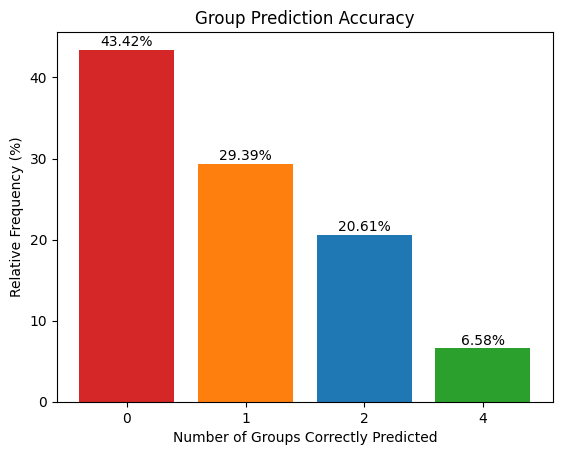

In [9]:
def visualize_group_prediction_accuracy(num_correct_groups):
    labels, counts = np.unique(num_correct_groups, return_counts=True)
    frequencies = counts / counts.sum()
    percentages = frequencies * 100
    colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green']
    rects = plt.bar([str(l) for l in labels], percentages, color = colors)
    plt.bar_label(rects, padding = 0.5, labels = [f"{p:.2f}%" for p in percentages])
    plt.title("Group Prediction Accuracy")
    plt.xlabel("Number of Groups Correctly Predicted")
    plt.ylabel("Relative Frequency (%)")
    plt.show()

visualize_group_prediction_accuracy(metrics["correct_groups"])

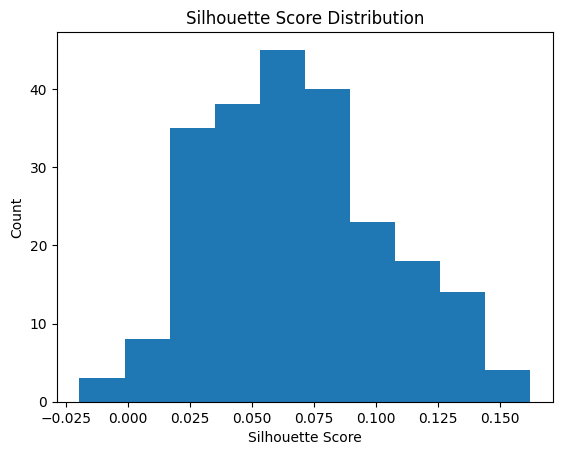

In [10]:
def visualize_silhouette_score(scores):
    plt.hist(scores)
    plt.title("Silhouette Score Distribution")
    plt.xlabel("Silhouette Score")
    plt.ylabel("Count")
    plt.show()

visualize_silhouette_score(metrics["silhouette_score"])

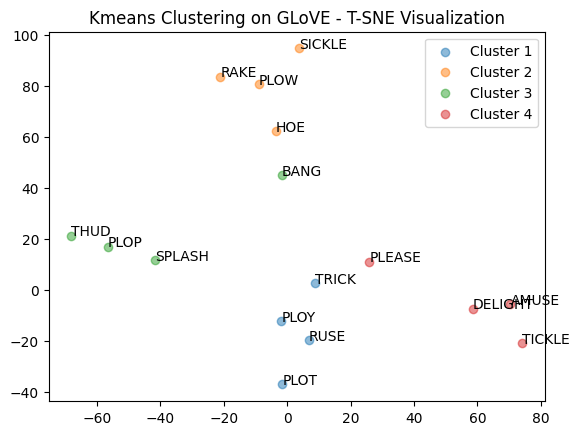

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_kmeans(X, game, cluster_labels):
    tsne = TSNE(perplexity=3)
    X_reduced = tsne.fit_transform(X)

    for cluster_label in np.unique(cluster_labels):
        plt.scatter(X_reduced[cluster_labels == cluster_label, 0], X_reduced[cluster_labels == cluster_label, 1], 
        label=f'Cluster {cluster_label+1}', alpha=0.5)

    for i, word in enumerate(game.flatten()):
        plt.annotate(word, (X_reduced[i, 0], X_reduced[i, 1]))

    plt.title('Kmeans Clustering on GLoVE - T-SNE Visualization')
    plt.legend()
    plt.show()

EX_SET_IDX = metrics["correct_groups"].index(4)
ex_set, ex_enc = sets[EX_SET_IDX], enc[EX_SET_IDX]
pred = metrics["predicted"][EX_SET_IDX]
visualize_kmeans(ex_enc, ex_set, pred)

In [154]:
correct_examples[:5]

[{frozenset({'JEAN', 'PANT', 'SHORT', 'TIGHT'}),
  frozenset({'PINCH', 'ROB', 'STEAL', 'SWIPE'}),
  frozenset({'BUCK', 'BULL', 'JACK', 'TOM'}),
  frozenset({'BILL', 'CHECK', 'INVOICE', 'TAB'})},
 {frozenset({'PLOT', 'PLOY', 'RUSE', 'TRICK'}),
  frozenset({'HOE', 'PLOW', 'RAKE', 'SICKLE'}),
  frozenset({'BANG', 'PLOP', 'SPLASH', 'THUD'}),
  frozenset({'AMUSE', 'DELIGHT', 'PLEASE', 'TICKLE'})},
 {frozenset({'LIME', 'MINT', 'RUM', 'SODA'}),
  frozenset({'COUNT', 'GROSS', 'SUM', 'TOTAL'}),
  frozenset({'GLUE', 'GUM', 'STICK', 'TAPE'}),
  frozenset({'HUM', 'SCAT', 'SING', 'WHISTLE'})},
 {frozenset({'CHOP', 'GRIND', 'PULSE', 'PUREE'}),
  frozenset({'CAPITAL', 'EQUITY', 'INTEREST', 'STOCK'}),
  frozenset({'CITY', 'COUNTY', 'TOWN', 'VILLAGE'}),
  frozenset({'IVY', 'JUSTICE', 'LITTLE', 'PREMIER'})},
 {frozenset({'HASH', 'JUMBLE', 'MEDLEY', 'STEW'}),
  frozenset({'BROOD', 'CLUTCH', 'HATCH', 'LITTER'}),
  frozenset({'CHALLENGE', 'CONFRONT', 'FACE', 'OPPOSE'}),
  frozenset({'BODY', 'BRIDGE', 'FRET

In [156]:
incorrect_examples[:4]

[({frozenset({'CHARGE', 'FINE', 'ICON', 'POPULAR'}),
   frozenset({'BIG', 'GLYPH', 'HIPPO', 'IN'}),
   frozenset({'ASSESS', 'HANDSOME', 'LEGEND', 'LEVY'})},
  {frozenset({'BIG', 'CHARGE', 'FINE', 'ICON'}),
   frozenset({'GLYPH', 'HIPPO', 'IN', 'LEGEND'}),
   frozenset({'ASSESS', 'HANDSOME', 'LEVY', 'POPULAR'})},
  3),
 ({frozenset({'CONE', 'IRIS', 'LENS', 'PUPIL'}),
   frozenset({'CALCULATOR', 'CALENDAR', 'CAMERA', 'CLOCK'}),
   frozenset({'EXPOSE', 'PATE', 'RESUME', 'ROSE'}),
   frozenset({'DADA', 'GRAMMY', 'MUM', 'POPPY'})},
  {frozenset({'CONE', 'IRIS', 'POPPY', 'ROSE'}),
   frozenset({'CALCULATOR', 'CALENDAR', 'CLOCK', 'RESUME'}),
   frozenset({'CAMERA', 'EXPOSE', 'LENS', 'PUPIL'}),
   frozenset({'DADA', 'GRAMMY', 'MUM', 'PATE'})},
  4),
 ({frozenset({'AT', 'DOLLAR', 'PERCENT', 'POUND'}),
   frozenset({'COIN', 'CREATE', 'DEVISE', 'INVENT'}),
   frozenset({'BAR', 'BUCK', 'TIME', 'TORCH'}),
   frozenset({'FINE', 'PRIME', 'QUALITY', 'STERLING'})},
  {frozenset({'AT', 'BAR', 'PRIME', '

In [157]:
# baseline
correct = 0
correct_sets = 0
for true_set, en in zip(sets, enc):
    pred_set = np.copy(true_set.reshape((16,)))
    np.random.shuffle(pred_set)
    pred_set = pred_set.reshape((4, 4))
    true_set = set(frozenset(true) for true in true_set)
    pred_set = set(frozenset(pred) for pred in pred_set)
    difference = true_set - pred_set
    correct += 1 if len(difference) == 0 else 0
    correct_sets += 4 - len(difference)

print(f"accuracy: {correct / len(sets):.60g}")
print(f"avg sets correct: {correct_sets / len(sets)}")

accuracy: 0
avg sets correct: 0.008771929824561403


In [111]:
clf = KMeansConstrained(
    n_clusters=4,
    size_min=4,
    size_max=4,
)

pred = clf.fit_predict(en)

ex_set = [sets[0].reshape((16))[np.where(example == i)] for i in range(0, 4)]
ex_set

[array(['BIG', 'HOT', 'IN', 'POPULAR'], dtype=object),
 array(['SYMBOL', 'FINE', 'HANDSOME', 'LIPID'], dtype=object),
 array(['CHARACTER', 'CHARGE', 'LEVY', 'LEGEND'], dtype=object),
 array(['GLYPH', 'ICON', 'ASSESS', 'HIPPO'], dtype=object)]

In [31]:
sets[0]

array([['ANKLET', 'BANGLE', 'BROOCH', 'PENDANT'],
       ['BIND', 'PICKLE', 'SCRAPE', 'SPOT'],
       ['IVY', 'JUSTICE', 'LITTLE', 'PREMIER'],
       ['BABY', 'GINGER', 'POSH', 'SCARY']], dtype=object)

In [36]:
np.all([set in sets[0] for set in ex_set])

False